# ACDC Challenge 

In this notebook we will try to obatain the best model for classiying CVD with the use of radiomics data.

We will create a pipeline to work through the data and compare the experiments

In [1]:
### import the packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFECV, RFE
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
# from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

## Machine Learning Pipeline

1. Dataset 
2. Feature Engineering/Selection
4. ML Algorithms
5. Training and Testing on ACDC Challenge Dataset

### 1. Dataset

We will load the training and test dataset, which contain the extracted radiomics of 100 and 50 patients, respectively. It will also contain the clinical data (only height and weight available) and the class of the patient (each of the 4 diseases or normal state). We will create a function to prepare the datasets.

In [2]:
train_df = pd.read_csv('Extracted_radiomics\ACDC_(Radiomics+Clinical)_Training.csv')
print(train_df.shape)
test_df = pd.read_csv('Extracted_radiomics\ACDC_(Radiomics+Clinical)_Testing.csv')
print(test_df.shape)

(100, 777)
(50, 777)


We know from prior knowledge that both the train and test dataset are equally balanced.

We also know that there are features that are not numeric and are just the product of the of the radiomics library that will not be needed for our model. We show them and we are going to eliminate them.

In [3]:
train_df = train_df.loc[:,~ train_df.columns.str.startswith('diagnostics')]
test_df = test_df.loc[:,~ test_df.columns.str.startswith('diagnostics')]
print(train_df.shape)
print(test_df.shape)

(100, 645)
(50, 645)


In [67]:
y_train = train_df['class']
y_test = test_df['class']

In [70]:
ED_train_df = train_df.filter(regex='ED')
ES_train_df = train_df.filter(regex='ES')

ED_test_df = test_df.filter(regex='ED')
ES_test_df = test_df.filter(regex='ES')

In [50]:
# ED_train_df = pd.concat([ED_train_df, class_df_train], axis=1)
# ES_train_df = pd.concat([ES_train_df, class_df_train], axis=1)

# ED_test_df = pd.concat([ED_test_df, class_df_test], axis=1)
# ES_test_df = pd.concat([ES_test_df, class_df_test], axis=1)

In [72]:
rad_train = pd.concat([ED_train_df, ES_train_df], axis = 1)
rad_test = pd.concat([ED_test_df, ES_train_df], axis = 1)

In [73]:
med_info_train = train_df.iloc[:,-3:-1]
med_info_test = test_df.iloc[:,-3:-1]

In [74]:
all_data_train = pd.concat([rad_train, med_info_train], axis=1)
all_data_test = pd.concat([rad_test, med_info_test], axis=1)

### 2. Feature Engineering/Selection

##### Feature Engineering
* MinMaxScaler for all the features 
* Encoding Class values 

In [66]:
def processing(X_train,y_train, X_test, y_test):
    #tools scaling and labelling
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.fit_transform(y_test)
    
    return X_train, y_train, X_test, y_test

##### Feature Selection

For this section we aim to apply several techiniques for feature selection and compare the performance with each proposed model/learning algorithm of the section 3

Set of Techniques we are going to use:
1. <u> K-Best </u>: This method is a **filter method**, which select features according the K-Highest Score of an statistical Test. For this one we are going to use both **Anova-Test** and **Chi-Suared-Test**.

2. <u> Sequential Forward Feature Elimination </u>: automatically select a subset of features that is most relevant to the problem. The goal of feature selection is two-fold: We want to improve the computational efficiency and reduce the generalization error of the model by removing irrelevant features or noise. http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-1-a-simple-sequential-forward-selection-example

#### Models

We combine Feature Selection methods as part of the Grid Search Method

In [63]:
def KBest_GS(X_train, y_train, X_test, y_test, model, param_grid):
    
    selector = SelectKBest()
    
    ### Pipeline
    
    ### we would need to adapt the "NUMBER OF FEATURES PARAMETER OF THE GRID"
    
    pipe = Pipeline([('selector', selector), 
                 ('model', model)])
    
    dict_1 = {'selector__score_func': [f_classif, chi2],
              'selector__k':featss}   #### para pruebas
    
    dict_1.update(param_grid)
    
    gs = GridSearchCV(estimator=pipe, 
                  param_grid=dict_1, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=StratifiedKFold(5),
                  iid=True,
                  refit=True,
                     verbose=3)
    
    print(pipe.get_params().keys())
    
    gs = gs.fit(X_train, y_train)
    
    print("Best Model", gs.best_params_)
    
    print('Best score:', gs.best_score_)
    
    y_test_pred = gs.predict(X_test)
    
    test_acc = accuracy_score(y_test,y_test_pred)
    
    print("\n Test Accuracy with best estimator: ", test_acc)
    
    cm = confusion_matrix(y_test, y_test_pred)
        
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,4))
    
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.tight_layout()

    class_list = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks, class_list, rotation=45)
    plt.yticks(tick_marks, class_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test, y_test_pred,target_names=class_list))
    
    cols = gs.best_estimator_.steps[0][1].get_support(indices=True)
    features_df_new = train_df.iloc[:,cols]
    K_best = list(features_df_new.columns)
    
    print(K_best)
    
    return gs
    

---

#### Sequential Foward Selection

In [64]:
def SFS_GS(X_train, y_train, X_test, y_test, model, param_grid):
    
    #Setting up the SFS
    sfs1 = SFS(estimator=model, 
           k_features=X_train.shape[1],
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=StratifiedKFold(4))
    
    ### Pipeline
    
    ### we would need to adapt the "NUMBER OF FEATURES PARAMETER OF THE GRID"
    
    pipe = Pipeline([('sfs', sfs1), 
                 ('model', model)])
    
    #dict_1 = {'sfs__k_features':list(range(1,X_train.shape[1]))}   #### para pruebas
    
    dict_1 = {'sfs__k_features':[5,10,15]}  #Testing
    
    dict_1.update(param_grid)
    
    gs = GridSearchCV(estimator=pipe, 
                  param_grid=dict_1, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=StratifiedKFold(5),
                  verbose=3,
                  refit=True)
    
    print(pipe.get_params().keys())
    
    gs = gs.fit(X_train, y_train)
    
#     print(gs.best_estimator_.steps)
    
    print("Best Model", gs.best_params_)
    
#     print('Best score:', gs.best_score_)
    
    y_test_pred = gs.predict(X_test)
    
    test_acc = accuracy_score(y_test,y_test_pred)
    
    print("\n Test Accuracy with best estimator: ", test_acc)
    
    cm = confusion_matrix(y_test, y_test_pred)
        
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,4))
    
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.tight_layout()

    class_list = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks, class_list, rotation=45)
    plt.yticks(tick_marks, class_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test, y_test_pred,target_names=class_list))
    
    feats = gs.best_estimator_.steps[0][1].k_feature_idx_
    
    feats_2= np.asanyarray(feats)
    
    print(train_df.iloc[:,feats_2].columns)
    
    return gs, pipe
    
    

In [75]:
#ED Alone
X_train_ED, y_train, X_test_ED, y_test = processing(ED_train_df, y_train, ED_test_df, y_test)

#ES Alone

X_train_ES, y_train, X_test_ES, y_test = processing(ES_train_df, y_train, ES_test_df, y_test)

#Radiomics 

X_train_rad, y_train, X_test_rad, y_test = processing(rad_train, y_train, rad_test, y_test)

#All data

X_train_all, y_train, X_test_all, y_test = processing(all_data_train, y_train, all_data_test, y_test)

### 3. ML Algorithms

Let's test some algorithms with the feature selection techniques

In [77]:
#Support Vector Classifier

model_SVC = SVC(gamma = 'scale', max_iter= 5000, random_state=42)

param_grid_SVC =  {'model__kernel':('linear', 'rbf'), 
                   'model__C':[0.5, 1, 10]}

# param_grid_SVC_nested =  { 'sfs__estimator__kernel': ['linear', 'rbf', 'poly']},
#                           {'degree':[1,5,10]},{
#                    'sfs__estimator__C':[5]}

param_grid_SVC_nested_2 =  { 'selector__estimator__kernel': ['linear', 'rbf'],
                   'selector__estimator__C':[15]}

param_grid_SVC_test_2 =  { 
                   'estimator__model__C':[0.5, 1,5,10]}


#-------------------------------------------------------

#Random Forest 

# Number of trees in random forest
n_estimators = [10, 100,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4,6,8,10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

param_grid_RF = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

param_grid_RF_nested = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}

param_grid_RF_2 = {'estimator__n_estimators': n_estimators,
               'estimator__bootstrap': bootstrap}

model_RF = RandomForestClassifier(random_state=42)

#--------------------------------------------------------------

# Logistic Regression

param_grid_LR_nested = {'model__penalty': ['l1','l2'], 
               'model__C': [0.1,1,10,100, 200]}

param_grid_LR = {'penalty': ['l1','l2'], 
               'C': [0.1,1,10,100, 200]}

model_LR = LogisticRegression( multi_class='auto', random_state=42)

#-------------------------------------------------------------------

### 4. Training and Testing on ACDC Challenge

dict_keys(['memory', 'steps', 'verbose', 'sfs', 'model', 'sfs__clone_estimator', 'sfs__cv', 'sfs__estimator__C', 'sfs__estimator__cache_size', 'sfs__estimator__class_weight', 'sfs__estimator__coef0', 'sfs__estimator__decision_function_shape', 'sfs__estimator__degree', 'sfs__estimator__gamma', 'sfs__estimator__kernel', 'sfs__estimator__max_iter', 'sfs__estimator__probability', 'sfs__estimator__random_state', 'sfs__estimator__shrinking', 'sfs__estimator__tol', 'sfs__estimator__verbose', 'sfs__estimator', 'sfs__fixed_features', 'sfs__floating', 'sfs__forward', 'sfs__k_features', 'sfs__n_jobs', 'sfs__pre_dispatch', 'sfs__scoring', 'sfs__verbose', 'sfs__svc', 'sfs__svc__C', 'sfs__svc__cache_size', 'sfs__svc__class_weight', 'sfs__svc__coef0', 'sfs__svc__decision_function_shape', 'sfs__svc__degree', 'sfs__svc__gamma', 'sfs__svc__kernel', 'sfs__svc__max_iter', 'sfs__svc__probability', 'sfs__svc__random_state', 'sfs__svc__shrinking', 'sfs__svc__tol', 'sfs__svc__verbose', 'model__C', 'model__cac

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=5, score=0.600, total=  18.8s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=5 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s


[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=5, score=0.650, total=  19.2s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=5 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.9s remaining:    0.0s


[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=5, score=0.450, total=  21.0s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=5 ...........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=5, score=0.450, total=  19.0s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=5 ...........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=5, score=0.400, total=  17.1s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=10 ..........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=10, score=0.450, total=  35.0s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=10 ..........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=10, score=0.650, total=  35.8s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=10 ..........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=10, score=0.450, total=  36.1s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=10 ..........
[CV]  model__C=0.5, model__kernel=linear, s

[CV]  model__C=1, model__kernel=rbf, sfs__k_features=15, score=0.650, total=  59.9s
[CV] model__C=1, model__kernel=rbf, sfs__k_features=15 ...............
[CV]  model__C=1, model__kernel=rbf, sfs__k_features=15, score=1.000, total=  56.9s
[CV] model__C=1, model__kernel=rbf, sfs__k_features=15 ...............
[CV]  model__C=1, model__kernel=rbf, sfs__k_features=15, score=0.800, total=  54.6s
[CV] model__C=1, model__kernel=rbf, sfs__k_features=15 ...............
[CV]  model__C=1, model__kernel=rbf, sfs__k_features=15, score=0.850, total=  54.1s
[CV] model__C=1, model__kernel=rbf, sfs__k_features=15 ...............
[CV]  model__C=1, model__kernel=rbf, sfs__k_features=15, score=0.700, total=  54.5s
[CV] model__C=10, model__kernel=linear, sfs__k_features=5 ............
[CV]  model__C=10, model__kernel=linear, sfs__k_features=5, score=0.750, total=  17.7s
[CV] model__C=10, model__kernel=linear, sfs__k_features=5 ............
[CV]  model__C=10, model__kernel=linear, sfs__k_features=5, score=0

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 53.6min finished


Best Model {'model__C': 0.5, 'model__kernel': 'rbf', 'sfs__k_features': 5}

 Test Accuracy with best estimator:  0.72


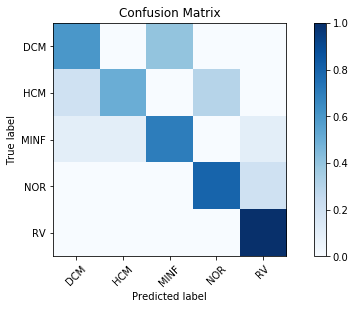

              precision    recall  f1-score   support

         DCM       0.67      0.60      0.63        10
         HCM       0.83      0.50      0.62        10
        MINF       0.64      0.70      0.67        10
         NOR       0.73      0.80      0.76        10
          RV       0.77      1.00      0.87        10

    accuracy                           0.72        50
   macro avg       0.73      0.72      0.71        50
weighted avg       0.73      0.72      0.71        50

Index(['original_ngtdm_Busyness_LV_ED',
       'original_glrlm_LongRunLowGrayLevelEmphasis_MYO_ED',
       'original_glrlm_GrayLevelNonUniformity_LV_ES',
       'original_shape_MeshVolume_RV_ES', 'original_shape_MeshVolume_MYO_ES'],
      dtype='object')


In [37]:
#gs, pipe = SFS_GS(X_train, y_train, X_test, y_test, model_SVC, param_grid_SVC)

In [39]:
#gs = KBest_GS(X_train, y_train, X_test, y_test, model_SVC, param_grid_SVC)

dict_keys(['memory', 'steps', 'verbose', 'selector', 'model', 'selector__k', 'selector__score_func', 'model__C', 'model__cache_size', 'model__class_weight', 'model__coef0', 'model__decision_function_shape', 'model__degree', 'model__gamma', 'model__kernel', 'model__max_iter', 'model__probability', 'model__random_state', 'model__shrinking', 'model__tol', 'model__verbose'])
Fitting 5 folds for each of 7716 candidates, totalling 38580 fits
[CV] model__C=0.5, model__kernel=linear, selector__k=1, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=1, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.350, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=1, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=1, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] model__C=0.5, model__kernel=linear, selector__k=5, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=5, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=5, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=5, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.350, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=6, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=6, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.250, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=6, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=6, selector__score_func=<function 

[CV]  model__C=0.5, model__kernel=linear, selector__k=11, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=11, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=11, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=11, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=11, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=11, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=11, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=11, selecto

[CV]  model__C=0.5, model__kernel=linear, selector__k=17, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=17, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=17, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=17, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=17, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=17, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=17, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=18, selector__sc

[CV]  model__C=0.5, model__kernel=linear, selector__k=23, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=23, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=23, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=23, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=23, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=23, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=23, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=23, selector__sc

[CV]  model__C=0.5, model__kernel=linear, selector__k=29, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=29, selecto

[CV]  model__C=0.5, model__kernel=linear, selector__k=35, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=35, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=35, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=35, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=35, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=35, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=35, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=35, selector__sc

[CV]  model__C=0.5, model__kernel=linear, selector__k=40, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=40, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=40, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=40, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=40, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=40, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=40, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=41, selector__sc

[CV]  model__C=0.5, model__kernel=linear, selector__k=45, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=45, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=45, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=46, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=46, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=46, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=46, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector

[CV]  model__C=0.5, model__kernel=linear, selector__k=50, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=50, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=50, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector

[CV]  model__C=0.5, model__kernel=linear, selector__k=56, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=56, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=56, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=56, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=56, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=56, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=56, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=5

[CV]  model__C=0.5, model__kernel=linear, selector__k=61, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=61, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=61, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=61, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=61, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=62, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=62, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=62, se

[CV] model__C=0.5, model__kernel=linear, selector__k=66, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=66, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=66, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=66, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=66, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=66, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=67, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=67, selector__score_func=<function f_c

[CV]  model__C=0.5, model__kernel=linear, selector__k=71, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=71, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=71, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=71, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=71, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=71, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=71, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=72, selector__sc

[CV]  model__C=0.5, model__kernel=linear, selector__k=76, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear

[CV]  model__C=0.5, model__kernel=linear, selector__k=82, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=82, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=82, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=82, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=82, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=82, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=82, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=l

[CV]  model__C=0.5, model__kernel=linear, selector__k=87, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=87, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=87, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=87, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=87, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=87, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=87, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=l

[CV]  model__C=0.5, model__kernel=linear, selector__k=91, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=91, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=91, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=91, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=91, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=91, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=91, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=92, selector__sc

[CV]  model__C=0.5, model__kernel=linear, selector__k=96, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=96, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=96, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=96, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=96, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=96, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=96, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=97, selector__sc

[CV]  model__C=0.5, model__kernel=linear, selector__k=101, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=101, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=101, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=101, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=101, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=101, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=101, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=110, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=111, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=111, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=111, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=111, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=111, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=111, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel

[CV]  model__C=0.5, model__kernel=linear, selector__k=115, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=115, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=115, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=116, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=116, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=116, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=116, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=120, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=120, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=120, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=120, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=120, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=120, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=120, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=120,

[CV]  model__C=0.5, model__kernel=linear, selector__k=125, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=125, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=125, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=125, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=125, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=125, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=125, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=129, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=129, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=129, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=129, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=129, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=129, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=129, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=130, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=133, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=133, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=133, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=134, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=134, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=134, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=134, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=138, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=138, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=138, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=138, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=138, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=138, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=138, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=138,

[CV]  model__C=0.5, model__kernel=linear, selector__k=144, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=144, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=144, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=145, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=145, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=145, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=145, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=148, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=148, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=148, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=148, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=148, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=148, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=148, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=148,

[CV]  model__C=0.5, model__kernel=linear, selector__k=152, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=152, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=152, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=152, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=152, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=153, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=153, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=156, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=157, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=157, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=157, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=157, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=157, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=157, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel

[CV]  model__C=0.5, model__kernel=linear, selector__k=161, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=161, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=161, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=161, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=161, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=161, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=161, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=162, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=166, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=166, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=166, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=166, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=166, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=166, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=166, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=170, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=170, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=170, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=170, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=170, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=170, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=170, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=170,

[CV]  model__C=0.5, model__kernel=linear, selector__k=174, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=174, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=174, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=174, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=174, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=174, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=174, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=175, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=178, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel

[CV]  model__C=0.5, model__kernel=linear, selector__k=183, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=183, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=183, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=183, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=183, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=183, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=183, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=187, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=187, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=187, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=187, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=187, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=187, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=187, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=187, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=191, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=191, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=191, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=191, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=191, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=191, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=191, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=192, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=195, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=195, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=195, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=195, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=195, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=195, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=195, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=199, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=199, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=199, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=199, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=199, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=199, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=199, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=199,

[CV]  model__C=0.5, model__kernel=linear, selector__k=203, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=203, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=203, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=203, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=203, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=204, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=204, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV] model__C=0.5, model__kernel=linear, selector__k=207, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=207, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=207, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=207, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=208, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=208, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=208, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=208, selector__score_

[CV]  model__C=0.5, model__kernel=linear, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=216, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=216, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=216, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=216, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=216, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=216, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=216, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=219, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=219, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=219, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=220, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=220, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=220, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=220, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=223, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=223, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=223, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=224, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=224, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=224, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=224, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=228, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=228, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=231, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=231, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=231, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=231, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=231, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=231, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=231, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=231, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=235, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=235, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=235, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=235, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=235, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=235, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=235, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=235,

[CV]  model__C=0.5, model__kernel=linear, selector__k=239, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=239, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=239, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=239, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=239, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=239, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=239, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=242, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=242, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=242, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=243, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=243, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=243, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=243, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=246, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=246, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=246, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=246, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=246, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=247, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=247, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=250, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=250, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=250, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=250, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=250, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=250, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=250, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=250, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=254, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=254, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=254, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=254, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=254, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=254, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=254, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=254,

[CV]  model__C=0.5, model__kernel=linear, selector__k=258, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=258, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=258, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=258, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=258, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=258, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=258, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__k

[CV] model__C=0.5, model__kernel=linear, selector__k=261, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=261, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=261, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=261, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=261, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=261, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=261, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=261, selector__score_func=

[CV]  model__C=0.5, model__kernel=linear, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=268, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=268, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=268, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=268, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=268, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=269, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=269, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV] model__C=0.5, model__kernel=linear, selector__k=272, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=272, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=272, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=272, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=272, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=272, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=272, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=272, selector__score_func=<function 

[CV]  model__C=0.5, model__kernel=linear, selector__k=276, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=276, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=276, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=276, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=276, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=276, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=276, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=279, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=279, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=279, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=279, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=279, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=279, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=279, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=279, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=282, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel

[CV]  model__C=0.5, model__kernel=linear, selector__k=286, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=286, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=286, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=286, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=286, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=287, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=287, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=290, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=290, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=290, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=290, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=290, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=290, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=290, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=293, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=293, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=293, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=294, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=294, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=294, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=294, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=297, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=297, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=297, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=297, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=297, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=297, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=297, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV] model__C=0.5, model__kernel=linear, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=300, selector__score_func=<function 

[CV]  model__C=0.5, model__kernel=linear, selector__k=304, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=304, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=304, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=304, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=304, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=304, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=304, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=307, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=307, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=307, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=307, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=307, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=307, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=307, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=307,

[CV]  model__C=0.5, model__kernel=linear, selector__k=310, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=310, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=310, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=311, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=311, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=311, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=311, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=314, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=314, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=314, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=314, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=314, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=314, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=314, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=317, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=317, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=317, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=317, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=317, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=318, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=318, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=320, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=320, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=320, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=321, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=321, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=321, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=321, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=324, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=324, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=324, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=324, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=324, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=324, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=324, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=327, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=327, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=327, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=327, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=327, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=327, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=327, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=331, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=336, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=336, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=336, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=336, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=336, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=336, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=336, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=336, sele

[CV] model__C=0.5, model__kernel=linear, selector__k=339, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=339, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=339, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=339, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=340, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=340, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=340, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=340, selector__score_

[CV]  model__C=0.5, model__kernel=linear, selector__k=343, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=343, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=343, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=343, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=343, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=343, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=343, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=346, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=346, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=346, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=346, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=346, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=346, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=346, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=349, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=349, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=349, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=349, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=349, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=349, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=349, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=350, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=355, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=358, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=358, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=358, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=358, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=358, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=359, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=359, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=361, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=361, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=361, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=362, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=362, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=362, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=362, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=368, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=368, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=368, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=368, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=368, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=368, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=368, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=371, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=371, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=371, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=371, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=371, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=371, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=371, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=377, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=377, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=377, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=377, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=377, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=377, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=377, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=380, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=380, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=380, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=380, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=380, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=380, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=380, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=386, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=386, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=386, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=386, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=386, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=386, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=386, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=392, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=392, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=392, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=392, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=392, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=392, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=392, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=395, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=395, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=395, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=395, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=395, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=395, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=395, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=401, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=401, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=401, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=401, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=401, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=401, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=401, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=407, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=407, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=407, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=407, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=407, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=407, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=407, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__k

[CV] model__C=0.5, model__kernel=linear, selector__k=412, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=412, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=412, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=412, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=412, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=412, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=412, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=412, selector__score_func=<function 

[CV]  model__C=0.5, model__kernel=linear, selector__k=417, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=417, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=417, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=417, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=417, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=418, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=418, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=423, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=423, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=423, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=423, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=423, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=423, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=423, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=428, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=428, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=428, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=428, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=428, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=428, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=428, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=429, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=434, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=434, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=434, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=434, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=434, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=434, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=434, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=438, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=438, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=438, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=438, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=438, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=439, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=439, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=443, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=443, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=443, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=443, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=443, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=443, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=443, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=448, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=448, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=448, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=448, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=448, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=448, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=448, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=452, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=452, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=452, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=452, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=452, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=452, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=452, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV] model__C=0.5, model__kernel=linear, selector__k=456, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=456, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=456, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=456, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=456, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=456, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=457, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=457, selector__score_func=<func

[CV]  model__C=0.5, model__kernel=linear, selector__k=461, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=461, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=461, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=461, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=461, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=461, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=461, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=465, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=465, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=465, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=465, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=465, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=465, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=465, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=465,

[CV]  model__C=0.5, model__kernel=linear, selector__k=469, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=470, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=470, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=470, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=470, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=470, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=470, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel

[CV] model__C=0.5, model__kernel=linear, selector__k=474, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=474, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=474, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=474, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=474, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=474, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=474, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=474, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=478, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=478, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=478, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=478, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=478, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=478, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=478, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=478, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=482, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=482, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=482, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=483, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=483, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=483, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=483, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=487, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=487, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=487, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=487, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=487, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=487, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=487, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=491, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=491, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=491, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=491, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=491, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=491, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=491, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=495, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=495, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=495, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=495, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=495, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=495, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=495, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=496, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=499, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=499, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=499, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=499, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=499, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=499, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=499, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=500, sele

[CV] model__C=0.5, model__kernel=linear, selector__k=503, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=503, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=504, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=504, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=504, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=504, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=504, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=504, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=508, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=508, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=508, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=508, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=508, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=508, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=508, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=512, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=512, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=512, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=512, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=512, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=512, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=512, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=516, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=516, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=516, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=516, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=516, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=516, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=516, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=520, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=520, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=520, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=520, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=520, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=520, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=520, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=520,

[CV]  model__C=0.5, model__kernel=linear, selector__k=524, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=524, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=524, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=524, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=524, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=524, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=524, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=528, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=528, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=528, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=528, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=528, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=528, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=528, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=532, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=532, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=532, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=532, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=532, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=532, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=532, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=536, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=536, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=536, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=536, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=536, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=536, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=536, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV] model__C=0.5, model__kernel=linear, selector__k=540, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=540, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=540, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=540, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=540, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=540, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=540, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=540, selector__score_func=

[CV]  model__C=0.5, model__kernel=linear, selector__k=544, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=544, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=544, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=544, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=544, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=544, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=544, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=548, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=548, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=548, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=548, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=548, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=548, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=548, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=552, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=552, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=552, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=552, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=552, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=552, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=552, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=555, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=555, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=555, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=556, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=556, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=556, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=556, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=559, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=559, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=559, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=560, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=560, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=560, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=560, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=563, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=563, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=563, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=563, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=563, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=564, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=564, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=567, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=567, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=567, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=567, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=567, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=567, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=567, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=567,

[CV]  model__C=0.5, model__kernel=linear, selector__k=571, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=571, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=571, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=571, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=571, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=571, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=571, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=571,

[CV]  model__C=0.5, model__kernel=linear, selector__k=575, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=575, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=575, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=575, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=575, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=575, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=575, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=578, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=578, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=578, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=579, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=579, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=579, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=579, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=582, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=582, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=582, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=582, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=582, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=583, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=583, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=586, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=586, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=586, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=586, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=586, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=586, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=586, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=589, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=590, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=590, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=590, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=590, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=590, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=590, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel

[CV]  model__C=0.5, model__kernel=linear, selector__k=593, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=593, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=593, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=593, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=593, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=593, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=593, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=594, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=597, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=597, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=597, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=597, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=597, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=597, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=597, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV] model__C=0.5, model__kernel=linear, selector__k=600, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=600, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=600, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=600, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=600, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=600, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=601, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=601, selector__score_func=<func

[CV]  model__C=0.5, model__kernel=linear, selector__k=604, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=604, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=604, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=604, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=604, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=604, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=604, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=607, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=608, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=608, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=608, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=608, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=608, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=608, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel

[CV]  model__C=0.5, model__kernel=linear, selector__k=611, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=611, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=611, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=611, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=611, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=611, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=611, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=612, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=615, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=615, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=615, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=615, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=615, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=615, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=615, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=618, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=618, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=618, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=618, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=618, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=618, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=618, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=618, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=622, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=622, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=622, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=622, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=622, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=622, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=622, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__k

[CV]  model__C=0.5, model__kernel=linear, selector__k=625, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=625, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=625, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=625, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=625, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=625, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=625, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=626, sele

[CV]  model__C=0.5, model__kernel=linear, selector__k=628, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=628, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=628, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=629, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=629, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=629, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=629, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=632, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=632, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=632, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=632, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=632, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=632, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=632, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, select

[CV]  model__C=0.5, model__kernel=linear, selector__k=635, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=635, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=635, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=636, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=636, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=636, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=636, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, s

[CV]  model__C=0.5, model__kernel=linear, selector__k=639, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=639, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=639, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=639, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=639, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=639, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=639, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=line

[CV]  model__C=0.5, model__kernel=linear, selector__k=642, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=642, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=642, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=642, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=642, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=642, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=linear, selector__k=642, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=linear, selector__k=643, sele

[CV]  model__C=0.5, model__kernel=rbf, selector__k=6, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=6, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=6, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=6, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=6, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=6, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=6, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=6, selector__score_func=<function chi2 at 

[CV]  model__C=0.5, model__kernel=rbf, selector__k=11, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=11, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=11, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=11, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=11, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=11, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=11, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=11, s

[CV]  model__C=0.5, model__kernel=rbf, selector__k=15, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=15, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=15, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=16, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=16, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=16, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=16, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=16, selector__score_

[CV]  model__C=0.5, model__kernel=rbf, selector__k=20, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=20, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=20, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=20, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=20, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=20, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=20, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=21, selector__score_func=<function f_cla

[CV]  model__C=0.5, model__kernel=rbf, selector__k=25, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=25, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=25, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=25, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=25, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=25, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=25, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=25, selector__score_func=

[CV]  model__C=0.5, model__kernel=rbf, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=29, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=30, selector__score_func=<function f_cla

[CV]  model__C=0.5, model__kernel=rbf, selector__k=33, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=34, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=34, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=34, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=34, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=34, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=34, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=34, select

[CV]  model__C=0.5, model__kernel=rbf, selector__k=38, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=38, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=38, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=38, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=38, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=38, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=38, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=38, s

[CV]  model__C=0.5, model__kernel=rbf, selector__k=42, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=42, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=42, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=42, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=42, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=42, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=42, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=42, selector__score_func=

[CV]  model__C=0.5, model__kernel=rbf, selector__k=46, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=46, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=46, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=46, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=46, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=46, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=46, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=47, selector__score_func=<function f_cla

[CV]  model__C=0.5, model__kernel=rbf, selector__k=50, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=51, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=51, select

[CV]  model__C=0.5, model__kernel=rbf, selector__k=54, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=54, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=54, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=54, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=54, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=54, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=54, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=54, selector__score_func=<function chi2 

[CV]  model__C=0.5, model__kernel=rbf, selector__k=58, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=58, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=58, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=58, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=58, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=58, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=58, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=58, selector__s

[CV]  model__C=0.5, model__kernel=rbf, selector__k=62, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=62, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=62, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=62, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=62, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=62, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=62, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=62, s

[CV] model__C=0.5, model__kernel=rbf, selector__k=65, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=65, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=66, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=66, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=66, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=66, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=66, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=66, selector__score_func=<function f_class

[CV] model__C=0.5, model__kernel=rbf, selector__k=69, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=69, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=69, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=69, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=69, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=69, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=70, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=70, selector__score_func=<function f_classif at 0x000001CB7707

[CV]  model__C=0.5, model__kernel=rbf, selector__k=73, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=73, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=73, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=73, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=73, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=73, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=73, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=73, selector__score_func=<function 

[CV]  model__C=0.5, model__kernel=rbf, selector__k=76, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=77, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=77, select

[CV]  model__C=0.5, model__kernel=rbf, selector__k=80, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=80, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=80, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=80, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=80, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=81, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=81, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=81, selector__score_func=<func

[CV]  model__C=0.5, model__kernel=rbf, selector__k=84, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=84, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=84, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=84, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=84, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=84, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=84, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=84, selector__score_func=<function chi2 

[CV]  model__C=0.5, model__kernel=rbf, selector__k=88, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=88, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=88, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=88, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=88, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=88, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=88, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=88, selector__score_func=

[CV]  model__C=0.5, model__kernel=rbf, selector__k=92, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=92, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=92, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=92, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=92, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=92, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=92, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=92, s

[CV]  model__C=0.5, model__kernel=rbf, selector__k=95, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=95, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=95, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=95, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=95, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=95, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=95, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=95, selector__score_func=<function 

[CV] model__C=0.5, model__kernel=rbf, selector__k=98, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=98, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=99, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=99, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=99, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=99, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=99, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=99, selector__score_func=<function f_class

[CV] model__C=0.5, model__kernel=rbf, selector__k=102, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=102, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=102, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=102, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=102, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=102, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=102, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=102, selector__score_func=<function chi2 at 0x0000

[CV]  model__C=0.5, model__kernel=rbf, selector__k=105, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=106, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=106

[CV] model__C=0.5, model__kernel=rbf, selector__k=109, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=109, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=109, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=109, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=109, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=109, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=109, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=109, selector__score_func=<function chi2 at 0x0000

[CV]  model__C=0.5, model__kernel=rbf, selector__k=112, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=112, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=112, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=112, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=112, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=112, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=112, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=113, selector__score_func=<functi

[CV] model__C=0.5, model__kernel=rbf, selector__k=118, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=118, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=118, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=118, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=118, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=118, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=118, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=118, selector__score_func=<function chi2 at 0x000001CB770793

[CV]  model__C=0.5, model__kernel=rbf, selector__k=121, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=121, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=121, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=122, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=122, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=122, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=122, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=122, selector

[CV]  model__C=0.5, model__kernel=rbf, selector__k=125, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=125, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=125, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=125, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=125, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=125, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=125, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=125, selector__sco

[CV] model__C=0.5, model__kernel=rbf, selector__k=128, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=128, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=128, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=128, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=128, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=128, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=129, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=129, selector__score_func=<function f_classif at 0x0000

[CV]  model__C=0.5, model__kernel=rbf, selector__k=131, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=131, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=131, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=132, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=132, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=132, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=132, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=132, selector

[CV]  model__C=0.5, model__kernel=rbf, selector__k=137, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=137, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=137, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=138, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=138, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=138, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=138, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=138, selector

[CV]  model__C=0.5, model__kernel=rbf, selector__k=141, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=141, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=141, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=141, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=141, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=141, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=141, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=144, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=144, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=144, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=144, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=144, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=144, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=144, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=144, selector__sco

[CV]  model__C=0.5, model__kernel=rbf, selector__k=150, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=150, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=150, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=150, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=150, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=150, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=150, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=150, selector__sco

[CV]  model__C=0.5, model__kernel=rbf, selector__k=156, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=156, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=156, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=156, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=156, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=156, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=156, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=161, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=162, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=162, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=162, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=162, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.900, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=162, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=162, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=162

[CV]  model__C=0.5, model__kernel=rbf, selector__k=167, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=167, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=167, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=167, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=167, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=167, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=167, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=168, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=173, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=173, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=173, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=173, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=173, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=173, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=173, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=173, selector__score_func=<f

[CV]  model__C=0.5, model__kernel=rbf, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=179, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=179, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=179, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=179, sel

[CV] model__C=0.5, model__kernel=rbf, selector__k=184, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=184, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=184, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=184, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=185, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=185, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=185, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=185, selector__score_func=<function f_classif

[CV]  model__C=0.5, model__kernel=rbf, selector__k=190, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=190, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=190, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=190, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=190, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=190, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=190, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=190, selector__score_func=<f

[CV]  model__C=0.5, model__kernel=rbf, selector__k=196, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=196, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=196, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=196, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=196, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=196, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=196, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=201, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=201, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=201, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=201, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=201, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=201, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=201, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=201, selector__sco

[CV]  model__C=0.5, model__kernel=rbf, selector__k=206, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=206, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=206, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=207, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=207, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=207, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=207, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=207, selector

[CV]  model__C=0.5, model__kernel=rbf, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=212, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=212, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=212, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=212, sel

[CV]  model__C=0.5, model__kernel=rbf, selector__k=217, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=217, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=217, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=217, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=217, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=217, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=217, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=217, selector__sco

[CV]  model__C=0.5, model__kernel=rbf, selector__k=222, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=222, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=222, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=222, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=222, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=222, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=222, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=223, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=227, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=227, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=232, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=232, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=232, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=232, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=232, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=232, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=232, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=233, selector__score_func=<functi

[CV] model__C=0.5, model__kernel=rbf, selector__k=237, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=237, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=237, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=237, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=237, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=237, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=237, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=237, selector__score_func

[CV]  model__C=0.5, model__kernel=rbf, selector__k=241, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=241, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=241, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=241, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=241, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=241, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=241, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=241, selector__score_func=<f

[CV]  model__C=0.5, model__kernel=rbf, selector__k=246, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=246, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=246, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=246, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=246, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=246, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=246, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=246, sel

[CV] model__C=0.5, model__kernel=rbf, selector__k=251, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=251, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=251, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=251, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=251, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=251, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=251, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=251, selector__score_func

[CV]  model__C=0.5, model__kernel=rbf, selector__k=255, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=255, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=255, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=255, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=255, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=255, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=255, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=256, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=260, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=260, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=260, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=260, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=260, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=260, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=260, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=260, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=265, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=265, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=265, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=265, sel

[CV]  model__C=0.5, model__kernel=rbf, selector__k=269, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=269, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=269, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=269, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=269, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=269, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=269, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=269, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=274, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=274, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=274, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=274, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=274, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=274, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=274, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=278, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=278, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=278, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=278, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=278, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=278, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=278, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=278, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=283, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=287, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=287, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=287, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=287, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=287, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=287, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=287, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=288, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=292, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=292, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=292, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=292, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=292, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=292, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=292, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=296, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=296, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=296, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=296, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=296, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=296, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=296, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=296, selector__score_func=<f

[CV]  model__C=0.5, model__kernel=rbf, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=300, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=301, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=301, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=301, selector__score_fu

[CV]  model__C=0.5, model__kernel=rbf, selector__k=305, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=305, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=305, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=305, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=305, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=305, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=305, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=305, sel

[CV]  model__C=0.5, model__kernel=rbf, selector__k=309, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=309, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=309, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=309, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=309, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=309, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=309, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=309, selector__score_func=<f

[CV]  model__C=0.5, model__kernel=rbf, selector__k=313, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=313, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=313, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=314, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=314, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=314, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=314, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=314, selector

[CV]  model__C=0.5, model__kernel=rbf, selector__k=318, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=318, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=318, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=318, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=318, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=318, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=318, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=322, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=322, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=322, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=322, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=322, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=322, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=322, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=322, selector__score_func=<f

[CV]  model__C=0.5, model__kernel=rbf, selector__k=326, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=326, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=326, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=326, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=326, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=326, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=326, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=327, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=330, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=331, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=334, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=334, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=334, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=334, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=334, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=335, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=335, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=335, selector__score_fu

[CV] model__C=0.5, model__kernel=rbf, selector__k=338, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=338, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=338, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=338, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=338, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=338, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=338, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=338, selector__score_func=<function chi2 at 0x000001CB770793

[CV]  model__C=0.5, model__kernel=rbf, selector__k=342, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=342, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=342, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=342, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=342, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=342, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=342, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=345, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=345, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=345, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=345, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=345, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=345, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=345, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=346, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=349, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=349, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=349, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=349, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=349, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=349, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=349, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=352, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=352, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=352, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=352, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=352, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=352, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=352, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.850, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=352, selector__sco

[CV]  model__C=0.5, model__kernel=rbf, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=355, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=356, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=356, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=356, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=356, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=356, selector

[CV]  model__C=0.5, model__kernel=rbf, selector__k=359, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=359, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=359, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=359, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=359, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.800, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=359, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=359, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=359, selector__score_func=<f

[CV]  model__C=0.5, model__kernel=rbf, selector__k=363, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=363, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=363, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=363, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=363, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=363, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=363, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=363, selector__sco

[CV]  model__C=0.5, model__kernel=rbf, selector__k=367, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=367, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=367, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=367, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=367, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=367, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=367, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=370, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=370, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=370, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=370, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=370, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=371, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=371, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=371, selector__score_fu

[CV]  model__C=0.5, model__kernel=rbf, selector__k=374, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=374, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=374, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=374, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=374, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=374, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=374, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=374, selector__score_func=<f

[CV]  model__C=0.5, model__kernel=rbf, selector__k=378, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=378, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=378, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=378, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=378, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=378, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=378, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=381, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=381, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=381, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=381, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=381, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=382, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=382, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=382, selector__score_fu

[CV]  model__C=0.5, model__kernel=rbf, selector__k=385, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=385, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=385, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=385, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=385, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=385, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=385, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=386, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=389, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=389, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=389, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=389, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=389, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.750, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=389, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=389, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=389, selector__score_func=<f

[CV]  model__C=0.5, model__kernel=rbf, selector__k=392, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=393, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=393, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=393, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=393, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=393, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=393, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=393

[CV]  model__C=0.5, model__kernel=rbf, selector__k=396, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=396, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=396, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=396, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=396, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=396, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=396, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=396, selector__sco

[CV]  model__C=0.5, model__kernel=rbf, selector__k=399, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=399, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=399, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=399, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=399, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=399, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=399, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=400, selector__score_func=<functi

[CV]  model__C=0.5, model__kernel=rbf, selector__k=404, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=404, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=404, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.650, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=404, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=404, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=404, selector__score_func=<function f_classif at 0x000001CB77079798> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=404, selector__score_func=<function f_classif at 0x000001CB77079798>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__

[CV]  model__C=0.5, model__kernel=rbf, selector__k=407, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.700, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=407, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=407, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.600, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=407, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=407, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=407, selector__score_func=<function chi2 at 0x000001CB770793A8> 
[CV]  model__C=0.5, model__kernel=rbf, selector__k=407, selector__score_func=<function chi2 at 0x000001CB770793A8>, score=0.550, total=   0.0s
[CV] model__C=0.5, model__kernel=rbf, selector__k=408, selector__score_func=<functi

KeyboardInterrupt: 

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11, score=0.650, total=  33.2s
[CV] sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.1s remaining:    0.0s


[CV]  sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11, score=0.600, total=  35.0s
[CV] sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11, score=0.700, total=  33.3s
[CV] sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11 
[CV]  sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11, score=0.700, total=  33.0s
[CV] sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11 
[CV]  sfs__estimator__C=5, sfs__estimator__kernel=linear, sfs__k_features=11, score=0.700, total=  33.0s
[CV] sfs__estimator__C=5, sfs__estimator__kernel=rbf, sfs__k_features=11 
[CV]  sfs__estimator__C=5, sfs__estimator__kernel=rbf, sfs__k_features=11, score=0.650, total=  33.2s
[CV] sfs__estimator__C=5, sfs__estimator__kernel=rbf, sfs__k_features=11 
[CV]  sfs__estimator__C=5, sfs__estimator__kernel=rbf, sfs__k_features=11, score=0.600, total=  33.1s
[CV] sfs__estimator__C=5, sfs__estimator__kernel=rbf, sfs__k_features=11 
[CV]  sfs__estimator__C=5, sfs__estimator__kernel=rbf, sfs__k_features=11, score=0.700, total=  33.5s
[CV

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.6min finished


Best Model {'sfs__estimator__C': 5, 'sfs__estimator__kernel': 'linear', 'sfs__k_features': 11}

 Test Accuracy with best estimator:  0.52


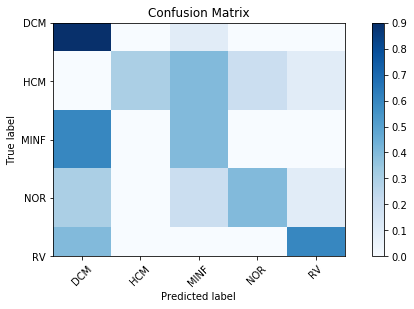

              precision    recall  f1-score   support

         DCM       0.41      0.90      0.56        10
         HCM       1.00      0.30      0.46        10
        MINF       0.36      0.40      0.38        10
         NOR       0.67      0.40      0.50        10
          RV       0.75      0.60      0.67        10

    accuracy                           0.52        50
   macro avg       0.64      0.52      0.51        50
weighted avg       0.64      0.52      0.51        50

Index(['original_glszm_LargeAreaHighGrayLevelEmphasis_LV_ED',
       'original_gldm_SmallDependenceHighGrayLevelEmphasis_RV_ED',
       'original_glszm_HighGrayLevelZoneEmphasis_RV_ED',
       'original_shape_SurfaceVolumeRatio_MYO_ED',
       'original_glcm_ClusterProminence_MYO_ED',
       'original_gldm_SmallDependenceHighGrayLevelEmphasis_MYO_ED',
       'original_glrlm_LongRunHighGrayLevelEmphasis_MYO_ED',
       'original_shape_LeastAxisLength_LV_ES',
       'original_gldm_LargeDependenceHighGrayLeve

In [148]:
#gs, pipe = SFS_GS(X_train, y_train, X_test, y_test, model_SVC, param_grid_SVC_nested)